# Classification_Semiconductor process data
#### 2024.7.30
#### Chulwon Chae


### Purpose of Data Analysis
    - Utilize semiconductor process data to determine whether the quality of semiconductor products produced in the process is Pass/Fail.
    - Identify problematic areas in the process and strengthen the competitiveness of the semiconductor process.

In [191]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from scipy.stats import kruskal
from scipy.stats import shapiro


# library for sampling 
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

# library for machine learning
import sklearn
from sklearn.decomposition import PCA 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import shap

%matplotlib inline

## 1. Data Processing 1 

### 1-1 Data Load 

In [192]:
random_state = 1234
df = pd.read_csv('./data/5.Semi-conductor manufacturing process/uci-secom.csv')
df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


### 1-2 Duplicated Data 

In [194]:
print(len(df[df.duplicated()]))

0


## 2. Data EDA

### 2-1 Data Type and Summary

In [195]:
df.columns

Index(['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '581', '582', '583', '584', '585', '586', '587', '588', '589',
       'Pass/Fail'],
      dtype='object', length=592)

In [196]:
# categorical and numeric columns (if nunique() is 0, that column is no needed)
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].nunique())

Time object 1534
0 float64 1520
1 float64 1504
2 float64 507
3 float64 518
4 float64 503
5 float64 1
6 float64 510
7 float64 89
8 float64 1208
9 float64 568
10 float64 392
11 float64 378
12 float64 1547
13 float64 1
14 float64 1555
15 float64 1561
16 float64 1477
17 float64 281
18 float64 1548
19 float64 361
20 float64 552
21 float64 1295
22 float64 1176
23 float64 1480
24 float64 1494
25 float64 704
26 float64 624
27 float64 1148
28 float64 869
29 float64 188
30 float64 842
31 float64 1275
32 float64 338
33 float64 330
34 float64 329
35 float64 331
36 float64 330
37 float64 325
38 float64 329
39 float64 333
40 float64 291
41 float64 315
42 float64 1
43 float64 1523
44 float64 1376
45 float64 1520
46 float64 1562
47 float64 1341
48 float64 1486
49 float64 1
50 float64 1520
51 float64 1562
52 float64 1
53 float64 153
54 float64 169
55 float64 107
56 float64 187
57 float64 159
58 float64 382
59 float64 1500
60 float64 1498
61 float64 1418
62 float64 1518
63 float64 1534
64 float64 1496
6

In [197]:
# we will delete the time column.
df = df.drop("Time", axis=1).copy()
list_numeric_columns = list(df.select_dtypes(include = ['float64']).columns)
print(len(df.columns))
print(len(list_numeric_columns))

591
590


Missing Values

In [198]:
len(df.columns[df.isna().sum() != 0])

538

In [199]:
df.isna().sum().sort_values(ascending=False)

157          1429
292          1429
293          1429
158          1429
492          1341
             ... 
120             0
156             0
495             0
494             0
Pass/Fail       0
Length: 591, dtype: int64

/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


<Axes: >

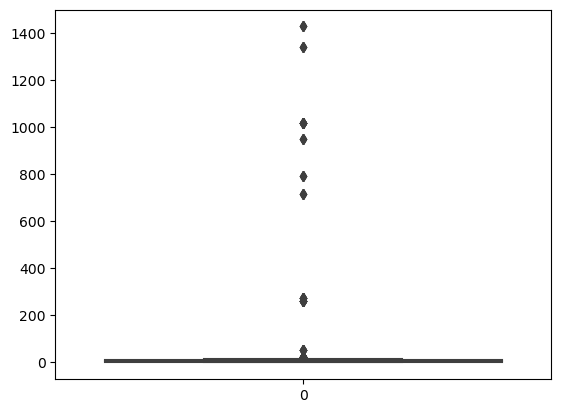

In [200]:
sns.boxplot(df.isna().sum())

##### Missing Values

In [201]:
size_df= len(df)
size_df

1567

In [202]:
# If nan is more than 50%, drop the column
list_drop_column = df.columns[df.isna().sum()>size_df*0.5]
df = df.drop(list_drop_column,axis=1)

In [203]:
df.isna().sum()

0             6
1             7
2            14
3            14
4            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 563, dtype: int64

In [204]:
# the rest of NA will fill with 0
df = df.fillna(0)

In [205]:
len(df.columns[df.isna().sum() !=0])

0

In [206]:
# re-new the list_numeric
list_numeric_columns = list(df.select_dtypes(include=['float64']).columns)
print(len(list_numeric_columns))

562


In [207]:
target_column = "Pass/Fail"

#### Summary of Data Set
##### - Number of Variables : 562
    numeric variables : 561
    categorical variables : 0
    target variables : 1
##### - Number of observations : 1567
##### - Missing Cells : 538 columns -> 0 columns 
##### - Duplicated Rows : 0 

### 2-2 Dependent Data Explore

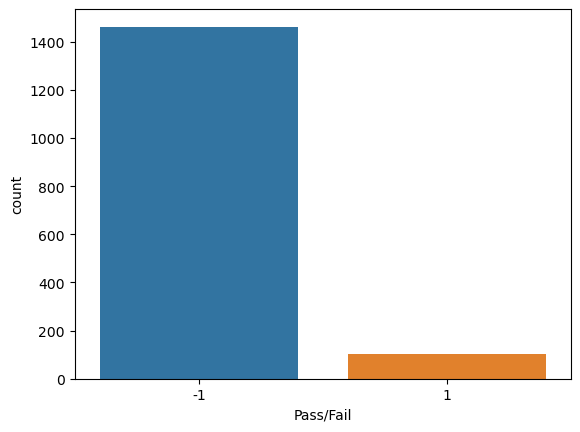

In [208]:
sns.countplot(x='Pass/Fail', data=df)
plt.show()

#### Approaches to Imbalanced Data
##### Data-Based Approaches
    1. Over-Sampling: Increase the number of instances in the minority class to balance the dataset.
    2. Under-Sampling: Decrease the number of instances in the majority class to balance the dataset. This method is not used in this practice.
    3. Combined Sampling: Combine both over-sampling and under-sampling to balance the classes.

#### ML Algorithm-Based Approaches (Cost Sensitive Method)
    1. Using ML Algorithms: Balance the classes by utilizing class weights during the ML training process.

### 2-3 Independent Data Explore

#### Numeric Data Analysis

In [209]:
df[list_numeric_columns].nunique().sort_values()

237       1
370       1
536       1
535       1
369       1
       ... 
423    1564
296    1565
460    1565
250    1566
115    1567
Length: 562, dtype: int64

In [210]:
list_2=df[list_numeric_columns].columns[df[list_numeric_columns].nunique() == 1]
for column_name in list_2:
    print(df.groupby(column_name)[column_name].count())

13
0.0    1567
Name: 13, dtype: int64
52
0.0    1567
Name: 52, dtype: int64
97
0.0    1567
Name: 97, dtype: int64
141
0.0    1567
Name: 141, dtype: int64
149
0.0    1567
Name: 149, dtype: int64
178
0.0    1567
Name: 178, dtype: int64
179
0.0    1567
Name: 179, dtype: int64
186
0.0    1567
Name: 186, dtype: int64
189
0.0    1567
Name: 189, dtype: int64
190
0.0    1567
Name: 190, dtype: int64
191
0.0    1567
Name: 191, dtype: int64
192
0.0    1567
Name: 192, dtype: int64
193
0.0    1567
Name: 193, dtype: int64
194
0.0    1567
Name: 194, dtype: int64
226
0.0    1567
Name: 226, dtype: int64
229
0.0    1567
Name: 229, dtype: int64
230
0.0    1567
Name: 230, dtype: int64
231
0.0    1567
Name: 231, dtype: int64
232
0.0    1567
Name: 232, dtype: int64
233
0.0    1567
Name: 233, dtype: int64
234
0.0    1567
Name: 234, dtype: int64
235
0.0    1567
Name: 235, dtype: int64
236
0.0    1567
Name: 236, dtype: int64
237
0.0    1567
Name: 237, dtype: int64
240
0.0    1567
Name: 240, dtype: int64
241
0.

In [211]:
# drop columns that the number of unique is 1 
df = df.drop(list_2, axis=1).copy()
list_numeric_columns= list(df.select_dtypes(include='float64').columns)
print(len(list_numeric_columns))

450


Columns' disctribution

In [212]:
df.describe().to_csv('./data/describe.csv')

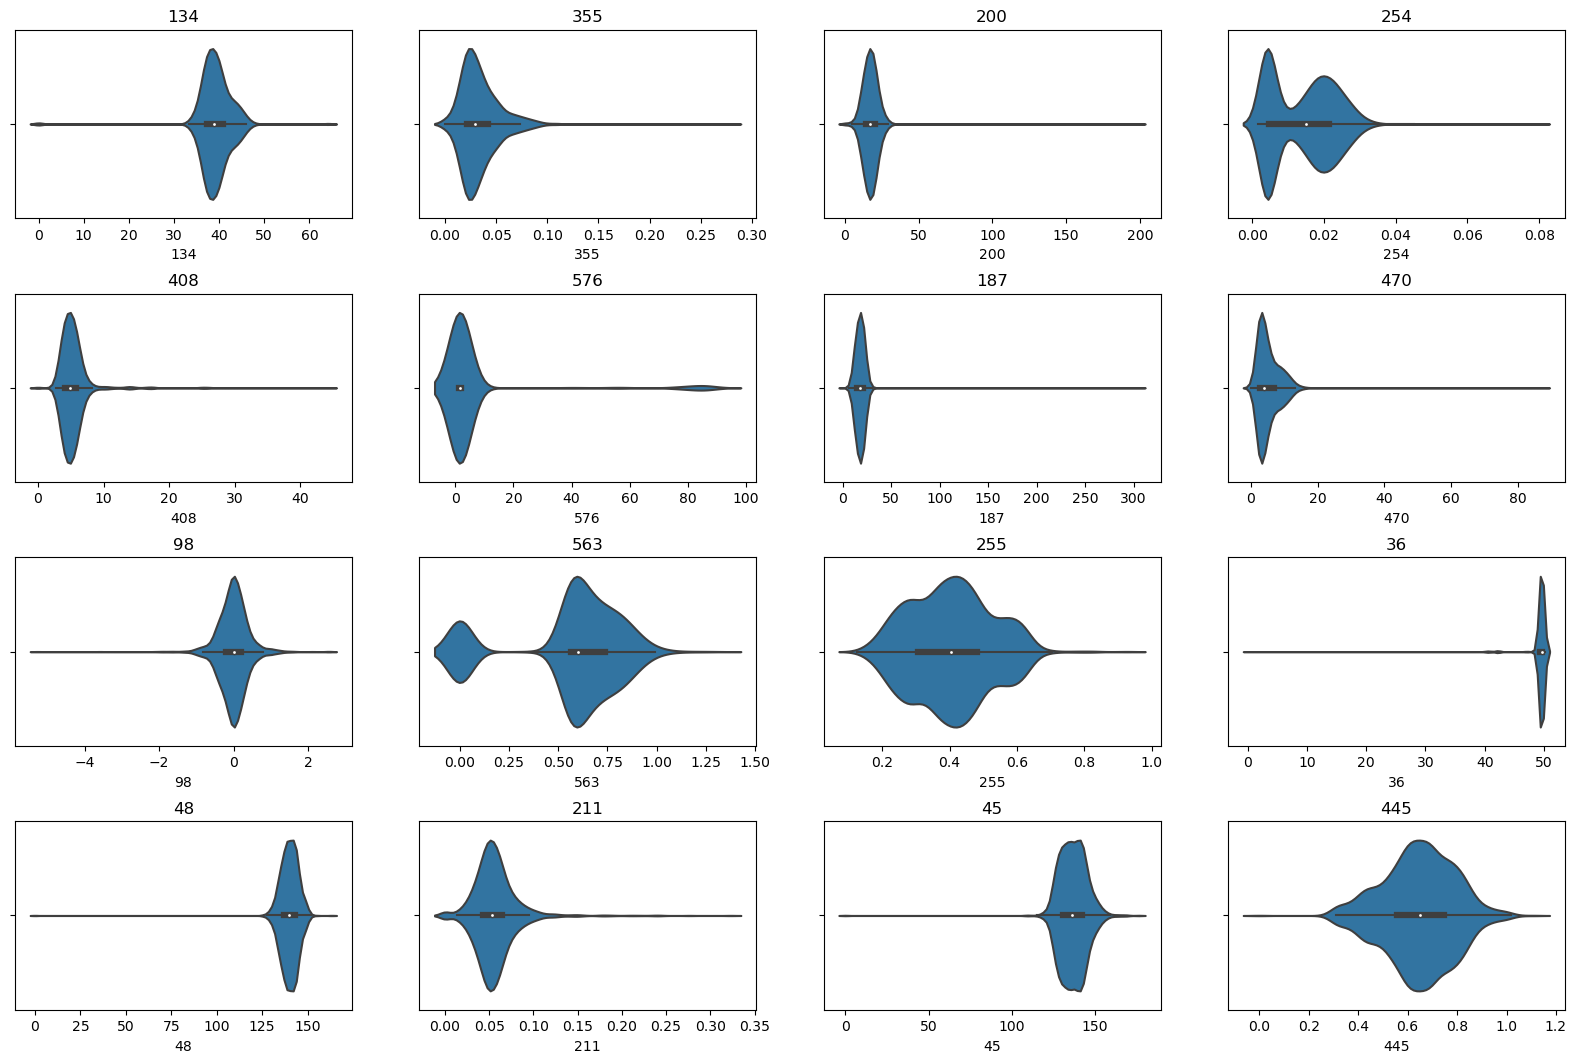

In [213]:
# check the distribution 
list_column_eda_randomly = random.choices(list_numeric_columns, k=16)
plt.figure(figsize=(20,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_column_eda_randomly:
    plt.subplot(4,4,x)
    x = x+1
    sns.violinplot(x=df[column_name])
    plt.title(column_name)
plt.show()
# need to scale

In [214]:
for column_name in list_numeric_columns:
    print(column_name, 'Skew : ', skew(df[column_name]), 
          'Kurt : ', kurtosis(df[column_name]))

0 Skew :  -12.884189012733302 Kurt :  191.13810014226064
1 Skew :  -10.834708878545632 Kurt :  143.31468782755323
2 Skew :  -10.125344703144867 Kurt :  102.64649208379164
3 Skew :  1.3404257867828315 Kurt :  4.349973037235833
4 Skew :  19.715083188111347 Kurt :  386.70793777673344
5 Skew :  -10.43731700383851 Kurt :  106.9375862386165
6 Skew :  -6.077971585809448 Kurt :  51.54840980262414
7 Skew :  -9.12567045307077 Kurt :  83.24763813684308
8 Skew :  -5.380696624194032 Kurt :  85.18936837017709
9 Skew :  0.3309003345147507 Kurt :  0.7961960247304258
10 Skew :  0.057728896930038284 Kurt :  1.5115721970077631
11 Skew :  -23.62996828976011 Kurt :  611.6568518108708
12 Skew :  -20.517083685030435 Kurt :  537.490624305603
14 Skew :  0.1205209919776421 Kurt :  0.08496405836603849
15 Skew :  -3.00984371338306 Kurt :  232.38130038225458
16 Skew :  35.19284587816267 Kurt :  1344.133307631435
17 Skew :  -20.731992963023004 Kurt :  446.60523618363186
18 Skew :  -19.421230241731703 Kurt :  418.06

##### Correlation Analysis

In [215]:
corr_all = df[list_numeric_columns].corr()

<Axes: >

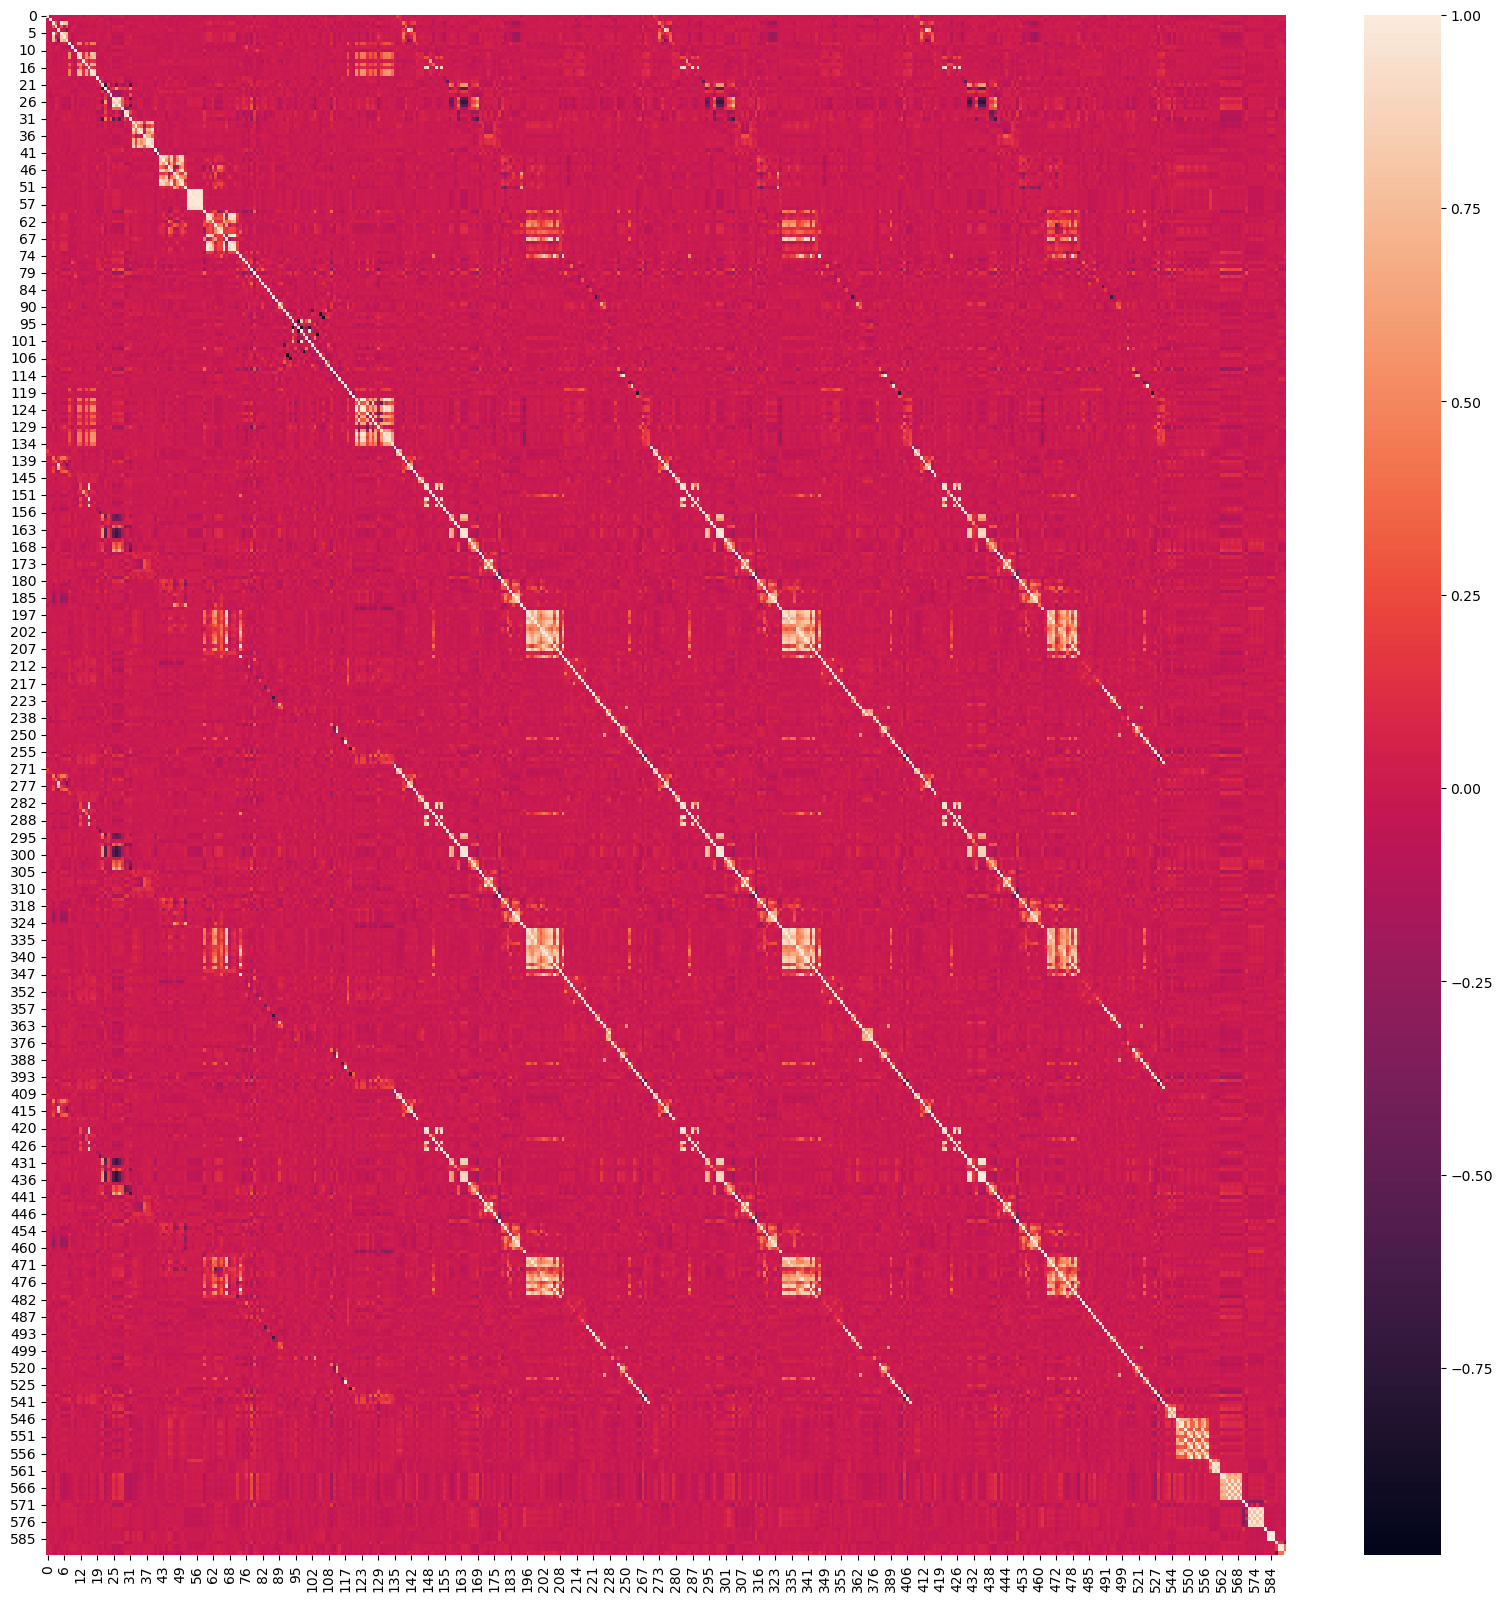

In [216]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_all)

In [217]:
# check if correlations are valid (esp. ones over 0.8)
index_corr_over_80 = np.where((abs(corr_all)>0.8) & (corr_all !=1))
print(len(index_corr_over_80[0]))
print(index_corr_over_80)

1300
(array([  2,   2,   4, ..., 445, 447, 448]), array([  5,   6, 131, ..., 444, 448, 447]))


In [218]:
len_corr_over_80 = len(index_corr_over_80[0])
left_columns = corr_all.columns[index_corr_over_80[0]]
right_columns = corr_all.columns[index_corr_over_80[1]]
for index in range(len_corr_over_80):
  print(left_columns[index], "<->", right_columns[index])  

2 <-> 5
2 <-> 6
4 <-> 140
4 <-> 275
4 <-> 413
5 <-> 2
5 <-> 6
6 <-> 2
6 <-> 5
11 <-> 12
11 <-> 17
12 <-> 11
16 <-> 147
16 <-> 148
16 <-> 152
16 <-> 154
16 <-> 282
16 <-> 283
16 <-> 287
16 <-> 289
16 <-> 420
16 <-> 421
16 <-> 425
16 <-> 427
17 <-> 11
17 <-> 18
18 <-> 17
25 <-> 26
25 <-> 27
26 <-> 25
27 <-> 25
29 <-> 30
30 <-> 29
32 <-> 34
32 <-> 39
34 <-> 32
34 <-> 35
34 <-> 39
35 <-> 34
37 <-> 38
37 <-> 39
38 <-> 37
38 <-> 39
39 <-> 32
39 <-> 34
39 <-> 37
39 <-> 38
42 <-> 43
42 <-> 44
42 <-> 46
42 <-> 49
42 <-> 50
43 <-> 42
43 <-> 46
43 <-> 49
43 <-> 50
44 <-> 42
44 <-> 49
46 <-> 42
46 <-> 43
46 <-> 49
46 <-> 50
49 <-> 42
49 <-> 43
49 <-> 44
49 <-> 46
49 <-> 50
50 <-> 42
50 <-> 43
50 <-> 46
50 <-> 49
53 <-> 54
53 <-> 55
53 <-> 56
53 <-> 57
53 <-> 58
54 <-> 53
54 <-> 55
54 <-> 56
54 <-> 57
54 <-> 58
55 <-> 53
55 <-> 54
55 <-> 56
55 <-> 57
55 <-> 58
56 <-> 53
56 <-> 54
56 <-> 55
56 <-> 57
56 <-> 58
57 <-> 53
57 <-> 54
57 <-> 55
57 <-> 56
57 <-> 58
58 <-> 53
58 <-> 54
58 <-> 55
58 <-> 56


In [219]:
#Random check 11
corr_11 = corr_all.loc[:,"11"].sort_values(ascending=False)
corr_11

11     1.000000
12     0.825783
17     0.812092
18     0.720854
15     0.556609
         ...   
288   -0.106236
147   -0.112953
282   -0.114473
420   -0.116069
426   -0.121474
Name: 11, Length: 450, dtype: float64

In [220]:
list_not_valid = []
for column_name in list(corr_11.head(10).index):
    statistic, pvalue = stats.pearsonr(df.loc[:,str(column_name)], df.loc[:,str(11)])
    if (pvalue > 0.05):
        print("%s %f %f"%(column_name, statistic, pvalue))
        list_not_valid.append(column_name)
print("end")
print(len(list_not_valid), " is not valids")

end
0  is not valids


In [221]:
list_not_valid = []
for column_name in list(corr_11.tail(10).index):
    statistic, pvalue = stats.pearsonr(df.loc[:,str(column_name)], df.loc[:,str(11)])
    if (pvalue > 0.05):
        print("%s %f %f"%(column_name, statistic, pvalue))
        list_not_valid.append(column_name)
print("end")
print(len(list_not_valid), " is not valids")

end
0  is not valids


accrdoing to pearson corr test, most of them are valid, but lets check visually.


/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_45062/3146307010.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=str(corr_11.index[i]), y="11", palette= "Set1", legend="full")
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_45062/3146307010.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title("corr : "+str(corr_11[i]))
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_45062/3146307010.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=str(corr_11.index[i]), y="11", palette= "Set1", legend="full")
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_45062/3146307010.py:7: FutureWarning: Series.__getitem__ treating keys as positions is

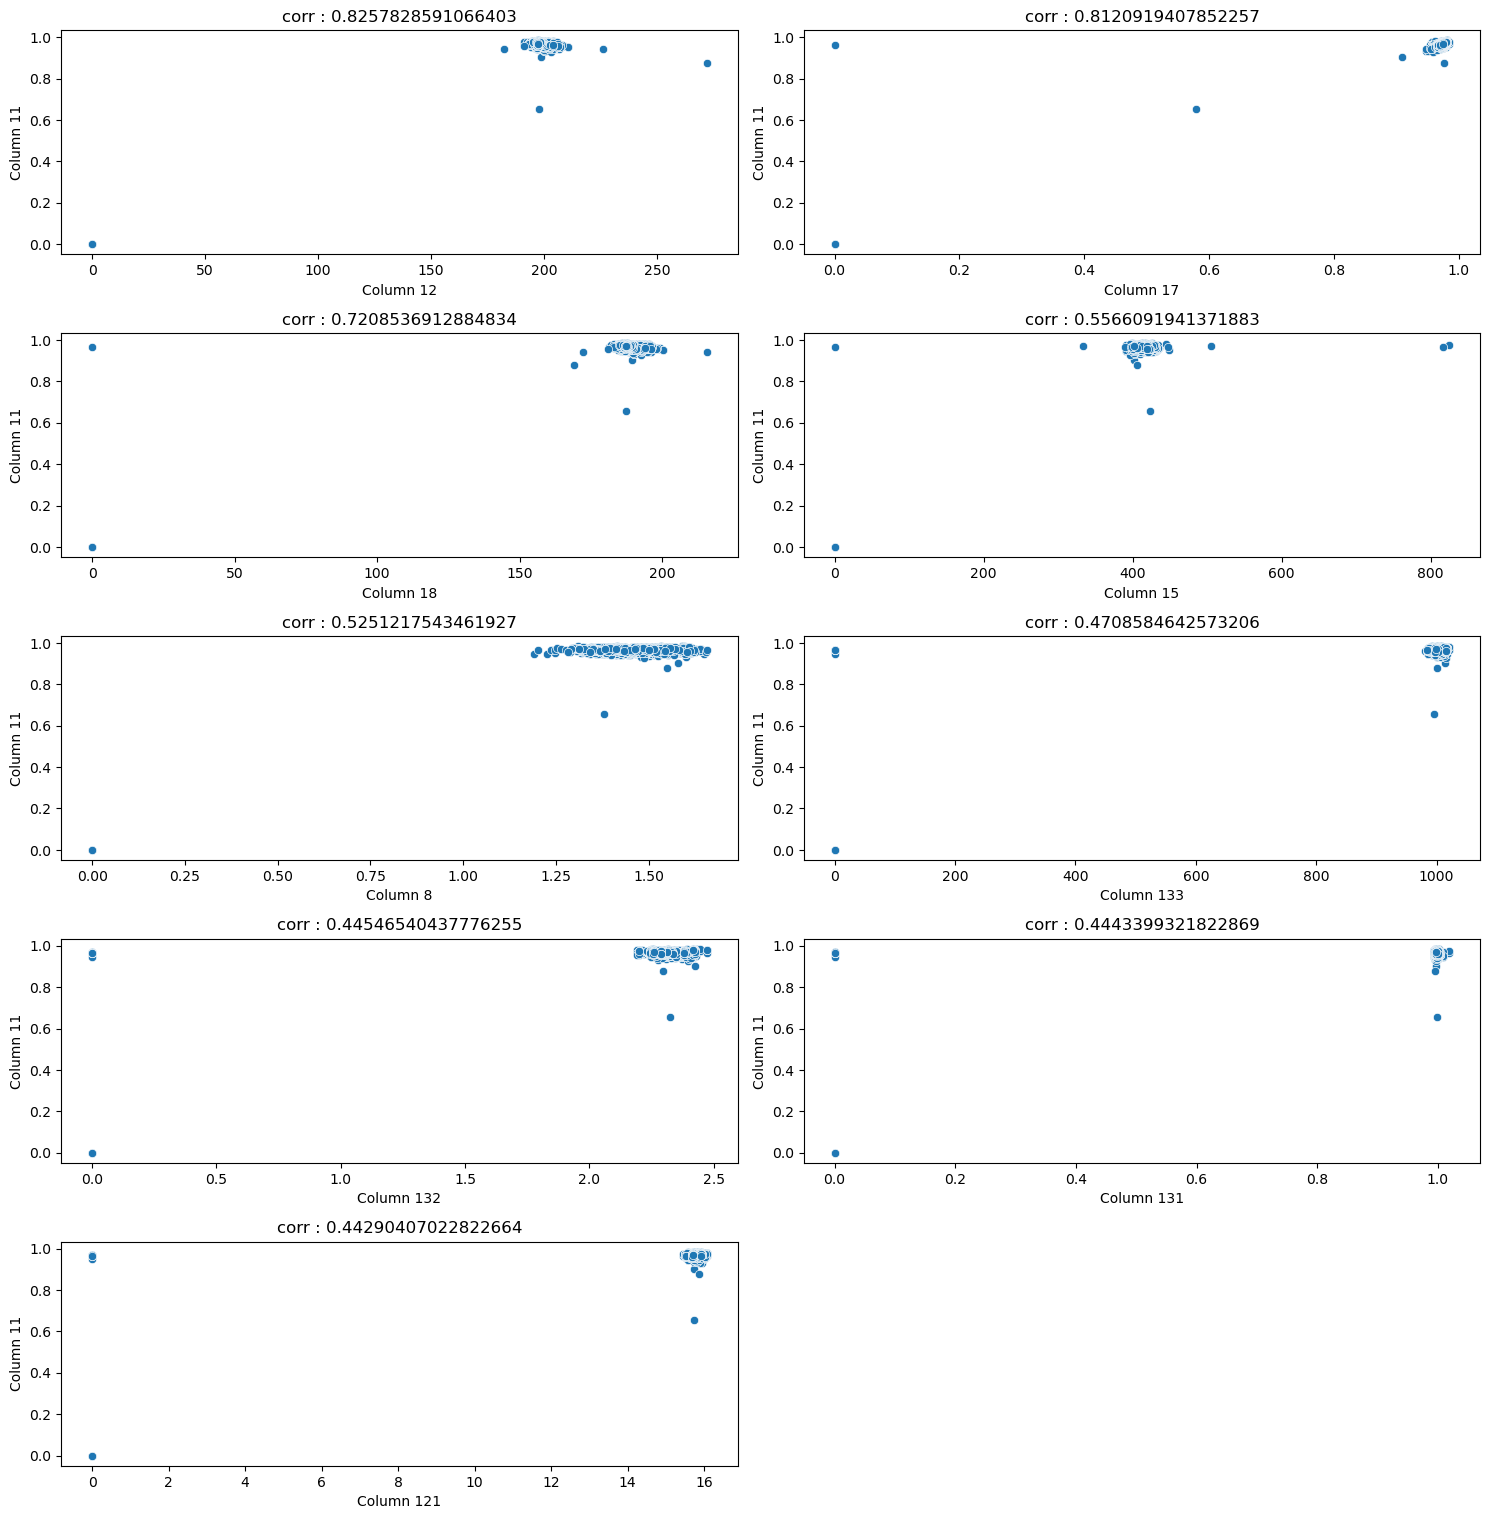

In [222]:
fig = plt.figure(figsize=(15,30))
for i in range(1,10):
    fig.add_subplot(10,2,i)
    sns.scatterplot(data=df, x=str(corr_11.index[i]), y="11", palette= "Set1", legend="full")
    plt.xlabel("Column "+str(corr_11.index[i]))
    plt.ylabel("Column 11")
    plt.title("corr : "+str(corr_11[i]))
    
fig.tight_layout()  
plt.show()



The correlation might appear as no effect due to some noise, so it's necessary to visually confirm using a scatter plot.

The correlation is high, but it seems to be due to noise.

Is the correlation coefficient of 0.8 in the first plot? It seems to be influenced by outliers.

##### Target Column and numeric Column distribution

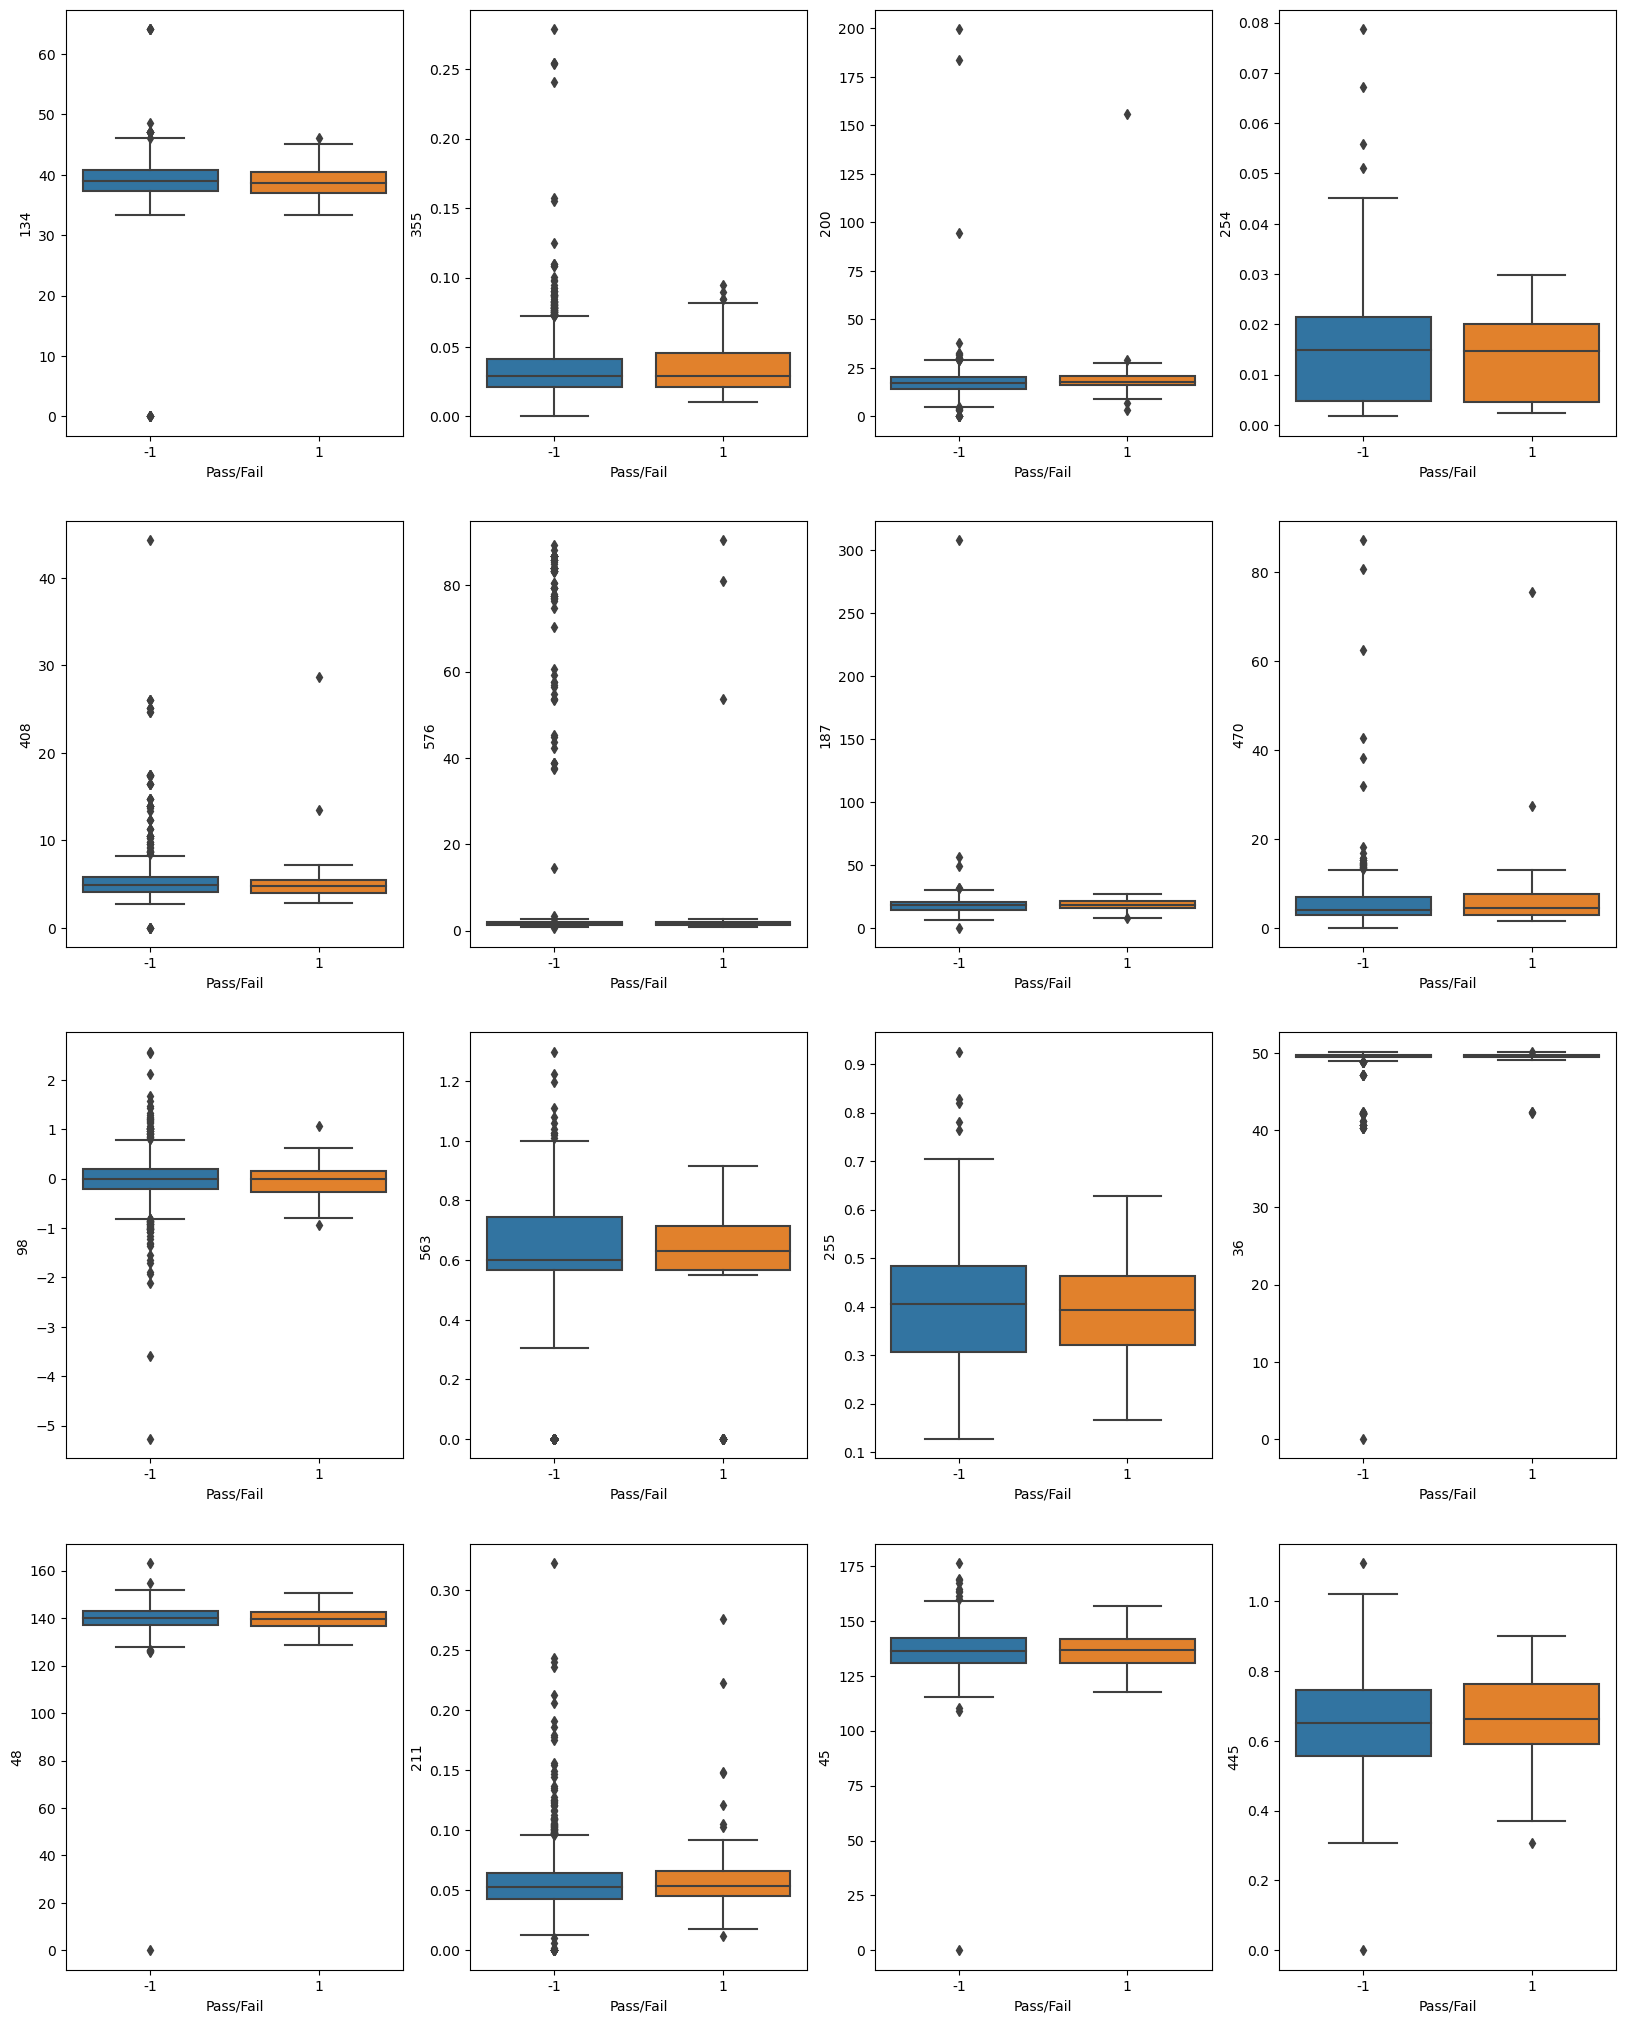

In [223]:
plt.figure(figsize=(20,20))
x=1
plt.subplots_adjust(top=0.99,bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_column_eda_randomly:
    plt.subplot(4,4,x)
    x = x+1
    sns.boxplot(data=df, x='Pass/Fail', y=column_name)
plt.show()

##### One-Way ANOVA
* Tests the differences in the distribution of numeric data across categories.
* For example, it can be used to test the differences in height distribution by gender.
* Assumptions: Normality, homogeneity of variances, independence (if these are not met, the test results may not be reliable).
* In this practice, we will test the relationship between the distribution of numerical columns based on categorical data.
* If the p-value is less than or equal to 0.05, we reject the null hypothesis (the p-value threshold can vary; while there is no exact standard, 0.05 is commonly used).
* H0 : No difference

In [224]:
# # 일원분산분석 수행
# model = ols('Height ~ C(Gender)', data=df).fit()          ##C = categorical
# anova_table = sm.stats.anova_lm(model, typ=2)

# print(anova_table)

# # p-value 확인
# p_value = anova_table['PR(>F)'][0]
# if p_value < 0.05:
#     print("성별에 따른 키의 차이가 통계적으로 유의미합니다.")
# else:
#     print("성별에 따른 키의 차이가 통계적으로 유의미하지 않습니다.")

In [225]:
# Shapiro-Wilk Test
# Null Hypothesis: The data follows a normal distribution.
# If p-value < 0.05, reject the null hypothesis.
for column_name in list_numeric_columns:
  statistic, pvalue = stats.shapiro(df[column_name])
  if pvalue >= 0.05:
    print(column_name)
print("end")


end


Normality Not Satisfied
* Since normality is not satisfied, there's no need to test for homogeneity of variances (homogeneity of variances assumes normality).
* It's not possible to test numeric data using one-way ANOVA.

##### Kruskal-Wallis Test (Non-parametric Test)
* As a non-parametric test, it doesn't require normality or homogeneity of variances.
* However, because it is a non-parametric test, the reliability of the results is lower compared to parametric tests.

In [226]:

list_meaningful_column_by_kruskall = []

for column_name in list_numeric_columns:
  list_by_value = []
  for value in df[target_column].dropna().unique():
      df_tmp = df[df[target_column] == value][column_name].dropna()
      list_by_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_numeric_columns))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

0 ,  4.278602996811264 ,  0.03859505728495665
1 ,  0.023947257401007612 ,  0.8770191876293454
2 ,  0.774301022396955 ,  0.3788897765838798
3 ,  0.009915812855657872 ,  0.9206792218376192
4 ,  0.004496812831036726 ,  0.9465353073417083
5 ,  1.0035461539431114 ,  0.3164539611480891
6 ,  0.07051246071491625 ,  0.790592094369279
7 ,  0.2933473721472008 ,  0.5880833975792443
8 ,  1.2799533401081409 ,  0.2579077110889926
9 ,  0.6516962442232054 ,  0.4195068800784897
10 ,  3.0109982802156585 ,  0.08270134371018575
11 ,  3.711943897853716 ,  0.05402443859057349
12 ,  0.05524336192830397 ,  0.8141784131335719
14 ,  5.9131159170342835 ,  0.015028566660551176
15 ,  0.2325061510623219 ,  0.6296717497219855
16 ,  2.3787874468234578 ,  0.12299298000810224
17 ,  1.6871575530017306 ,  0.19397609042719707
18 ,  0.024893487301571527 ,  0.8746327587779081
19 ,  0.16496986791243645 ,  0.6846214948322089
20 ,  0.7368709493989738 ,  0.39066507196640854
21 ,  13.273041806521796 ,  0.000269249978428174
22 ,  

#### Insight
1. Out of 590 numerical columns, 140 columns with insignificant data distribution were removed.
2. The numerical data showed high skewness and kurtosis values, indicating a need for transformation through preprocessing.
3. In the correlation analysis of numerical data, some showed high correlations; however, many of these were distorted by outliers, making them unreliable. This highlights the urgent need for dimensionality reduction.
4. A significant number of numerical data were found to have no meaningful relationship with Pass/Fail (the dependent variable). 81 columns were found to have significant differences in the Kruskal-Wallis test.
5. Utilize the results from point 4 for feature selection and model optimization.

## 3. Data Processing 2 

In [227]:
Y = df["Pass/Fail"]
X = df.drop(["Pass/Fail"], axis=1)

### 3-1 Label Encoding

In [228]:
le_encoder = LabelEncoder()
Y_encoded = le_encoder.fit_transform(Y)
Y_encoded

array([0, 0, 1, ..., 0, 0, 0])

In [229]:
Y

0      -1
1      -1
2       1
3      -1
4      -1
       ..
1562   -1
1563   -1
1564   -1
1565   -1
1566   -1
Name: Pass/Fail, Length: 1567, dtype: int64

### 3-2 Standardization and Normalization

In [230]:
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

- Standardization: Transforms data to have a mean of 0 and a standard deviation of 1. Adjusts the scale while maintaining the relative positions of the data. It can be affected by outliers.

- Normalization: Transforms the range of the data to a specific interval. Ensures all data is within the same range. It can be significantly affected by outliers.

In [231]:
scaler_minmax = MinMaxScaler()
X_base = scaler_minmax.fit_transform(X_standard)

In [232]:
X_base

array([[0.90304348, 0.9007743 , 0.94491632, ..., 0.        , 0.        ,
        0.        ],
       [0.92236507, 0.8660432 , 0.96335433, ..., 0.25156446, 0.20979021,
        0.28238593],
       [0.87374976, 0.89934796, 0.94434525, ..., 0.6057572 , 0.51748252,
        0.11238256],
       ...,
       [0.88751471, 0.83605486, 0.95293557, ..., 0.10763454, 0.08741259,
        0.05903   ],
       [0.8625203 , 0.8895357 , 0.94029483, ..., 0.30663329, 0.26223776,
        0.12680522],
       [0.87741743, 0.86099127, 0.94824687, ..., 0.20275344, 0.15734266,
        0.18687577]])

### 3-2 Sampling
SMOTE

In [233]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size = 0.25, random_state=random_state, stratify=Y_encoded)

In [234]:
sm = SMOTE(random_state=1234)
X_over, y_over = sm.fit_resample(X_train, y_train)

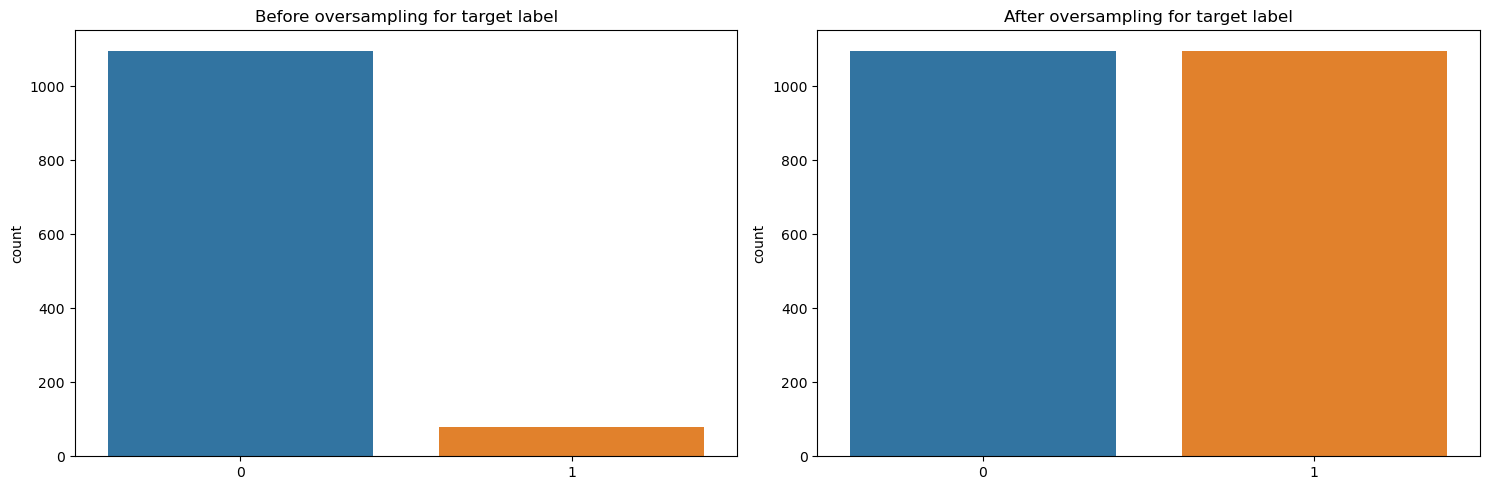

In [235]:
fig = plt.figure(figsize=(15, 5))

# Before oversampling
ax1 = fig.add_subplot(1, 2, 1)
sns.countplot(x=y_train, ax=ax1)
ax1.set_title("Before oversampling for target label")

# After oversampling
ax2 = fig.add_subplot(1, 2, 2)
sns.countplot(x=y_over, ax=ax2)
ax2.set_title("After oversampling for target label")

plt.tight_layout()
plt.show()

### 3-3 Feature Selection
#### Feature selection is performed using two methods:
1. Feature selection based on the Kruskal-Wallis test (using list_meaningful_column_by_Kruskall)
2. Feature selection using PCA dimensionality reduction

##### 1) Kruskall-Wallis Feature Selection

In [236]:
list_index_meaningful_column_by_kruskall = [X.columns.get_loc(x) for x in list_meaningful_column_by_kruskall]

In [237]:
X_fs_kruskall = X_over[:,list_index_meaningful_column_by_kruskall]
X_fs_kruskall

array([[0.89031537, 0.52406313, 0.19422398, ..., 0.        , 0.        ,
        0.20025031],
       [0.88947219, 0.5852659 , 0.19583231, ..., 0.        , 0.80532042,
        0.19899875],
       [0.91066188, 0.26641598, 0.21852383, ..., 0.22713031, 0.85228192,
        0.14893617],
       ...,
       [0.89402465, 0.5565559 , 0.15598268, ..., 0.03853622, 0.        ,
        0.21411615],
       [0.92753487, 0.38339464, 0.19132515, ..., 0.01084521, 0.86194138,
        0.16547739],
       [0.91988832, 0.50306331, 0.24855343, ..., 0.        , 0.86962733,
        0.21741244]])

In [238]:
X_validation_fs_kruskall = X_validation[:, list_index_meaningful_column_by_kruskall]
X_validation_fs_kruskall

array([[0.90881166, 0.5623155 , 0.0441593 , ..., 0.04041686, 0.        ,
        0.3379224 ],
       [0.8883132 , 0.44215077, 0.20292997, ..., 0.        , 0.84864677,
        0.0738423 ],
       [0.91541109, 0.35434988, 0.25827768, ..., 0.        , 0.84864677,
        0.09887359],
       ...,
       [0.89360168, 0.24769652, 0.09541624, ..., 0.        , 0.85674558,
        0.08010013],
       [0.87616607, 0.39146139, 0.12457606, ..., 0.        , 0.84864677,
        0.17647059],
       [0.91925753, 0.52415522, 0.20593686, ..., 0.03212768, 0.80054206,
        0.22778473]])

##### 2) Feature Selection with PCA

In [239]:
# 2D reduction
pca = PCA(n_components=2)
X_pca_two_dimension = pca.fit_transform(X_over)
df_pca_two_dimension = pd.DataFrame(X_pca_two_dimension)
df_pca_two_dimension["Pass/Fail"] = y_over
print("2D PCA Explainability : ",sum(pca.explained_variance_ratio_))

2D PCA Explainability :  0.16186906435879567


In [240]:
# 2D reduction
pca = PCA(n_components=3)
X_pca_three_dimension = pca.fit_transform(X_over)
df_pca_three_dimension = pd.DataFrame(X_pca_three_dimension)
df_pca_three_dimension["Pass/Fail"] = y_over
print("3D PCA Explainability : ",sum(pca.explained_variance_ratio_))

3D PCA Explainability :  0.20674441230410665


Text(0.5, 1.0, '2-D PCA')

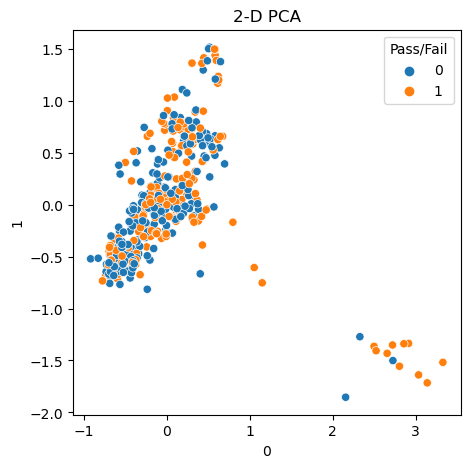

In [241]:
fig = plt.figure(figsize=(5,5))
sns.scatterplot(data=df_pca_three_dimension.sample(frac=0.2), x=0,y=1,hue="Pass/Fail")
plt.title('2-D PCA')

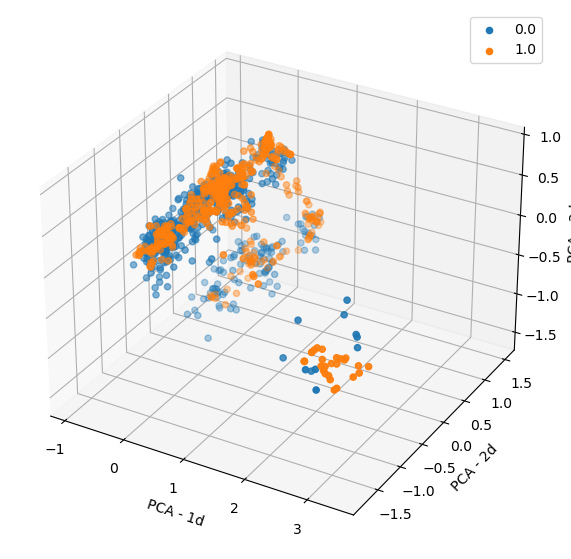

In [242]:
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(projection='3d')
df_3_pca_sampled = df_pca_three_dimension.sample(frac=0.5)
for i in [0.0,1.0]:
    list_index = (df_3_pca_sampled["Pass/Fail"] == i)
    ax.scatter3D(df_3_pca_sampled.loc[list_index,0],df_3_pca_sampled.loc[list_index,1],df_3_pca_sampled.loc[list_index,2], label=i)
ax.set_xlabel("PCA - 1d")
ax.set_ylabel("PCA - 2d")
ax.set_zlabel("PCA - 3d")
ax.legend(loc="upper right")


In [243]:
[i*10 for i in range(1,20)]

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190]

/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='dimension', ylabel='explained'>

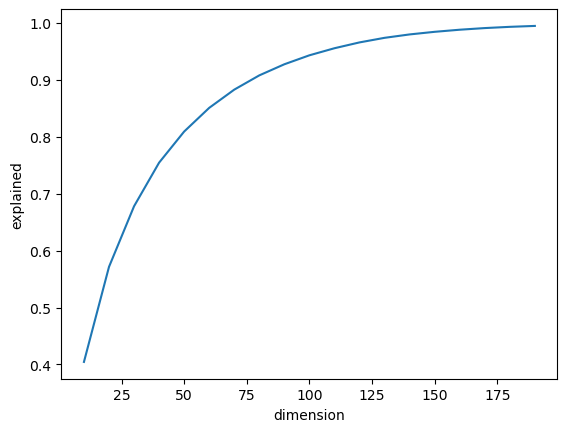

In [245]:
list_pca_explained_ratio = []
list_pca_candidate = [i*10 for i in range(1,20)] # 10~200
for i in list_pca_candidate:
    pca_tmp = PCA(n_components=i)
    pca_tmp.fit(X_over)
    list_pca_explained_ratio.append(sum(pca_tmp.explained_variance_ratio_))
sns.lineplot(data=pd.DataFrame(data={'dimension':list_pca_candidate, 'explained':list_pca_explained_ratio}), x='dimension',y='explained')

In [246]:
list_pca_explained_ratio[8]

0.9275838773160391

In [247]:
pca = PCA(n_components=90)
pca.fit(X_over) # must fit.
X_over_pca = pca.transform(X_over)

In [248]:
X_validation_pca = pca.transform(X_validation)

### 3-3 Summary
#### Generated three types of features for model optimization experiments:

1. Base Feature without feature changes (X_base, Y_encoded)
2. Oversampling and Feature Selection by Kruskal (X_fs_kruskal, y_over)
3. Oversampling and PCA with 90 dimensions (X_over_pca, y_over)

### 4. Model Analysis
1. Base model without feature change
2. Model Optimization 1: ML with Oversampling and Feature Selection by Kruskal
3. Model Optimization 2: ML with Oversampling and PCA
4. Model Optimization 3: Experiment with the top-performing features from the above results using three ML algorithm candidates (GBM, RF, SVM, MLP)

In [249]:
cv = 3
n_jobs = -1

### 4-1. Base Model Learning

In [250]:
print(X_train.shape)
print(y_train.shape)

(1175, 450)
(1175,)


In [251]:
list_model_auc_score = []

In [252]:
fruit = ['apple','banana','grape','peach','kiwi']
for e,i in enumerate(fruit):
    print(e,i)

0 apple
1 banana
2 grape
3 peach
4 kiwi


In [253]:
kf= StratifiedKFold(n_splits=5)
list_roc_score = []
for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    x_train_cv, x_test_cv = X_train[train_index,:], X_train[test_index,:]
    y_train_cv, y_test_cv = y_train[train_index],y_train[test_index]
    xgb_clf = GradientBoostingClassifier(max_depth = 5, n_estimators=5, learning_rate=0.2, random_state=random_state)
    xgb_clf.fit(x_train_cv, y_train_cv)
    y_prd = xgb_clf.predict_proba(X_validation)[:,-1]
    score = roc_auc_score(y_validation, y_prd)
    list_roc_score.append(score)

    print(i, score)

0 0.6185372005044136
1 0.7009773013871374
2 0.6749159310634719
3 0.6533207229928543
4 0.7152164775115595


In [254]:
print("stratified k fold cross-validation' roc mean : ", np.mean(list_roc_score))
list_model_auc_score.append(np.mean(list_roc_score))

stratified k fold cross-validation' roc mean :  0.6725935266918873


### 4-2. Model Optimization 1 : ML with Oversampling and Feature Selection by Kruskall

In [255]:
kf = StratifiedKFold(n_splits=5)
list_roc_score = []
for i, (train_index, test_index) in enumerate(kf.split(X_fs_kruskall, y_over)):
  x_train_cv, x_test_cv = X_fs_kruskall[train_index,:], X_fs_kruskall[test_index,:]
  y_train_cv, y_test_cv = y_over[train_index],y_over[test_index]
  xgb_clf = GradientBoostingClassifier(max_depth = 5, n_estimators=5, learning_rate=0.2, random_state=random_state)
  xgb_clf.fit(x_train_cv, y_train_cv)
  y_prd = xgb_clf.predict_proba(X_validation_fs_kruskall)[:,-1]
  score = roc_auc_score(y_validation, y_prd)
  list_roc_score.append(score)
  print(i, score)


0 0.6877364438839848
1 0.6970365699873896
2 0.7016078184110971
3 0.6910992013451029
4 0.7346574190836487


In [256]:
print("stratified k fold cross-validation' roc mean : ", np.mean(list_roc_score))
list_model_auc_score.append(np.mean(list_roc_score))

stratified k fold cross-validation' roc mean :  0.7024274905422445


### 4-3. Model Optimization 2 : Model Optimization 2 : ML with Oversampling and PCA

In [257]:
kf = StratifiedKFold(n_splits=5)
list_roc_score = []
for i, (train_index, test_index) in enumerate(kf.split(X_over_pca, y_over)):
  x_train_cv, x_test_cv = X_over_pca[train_index,:], X_over_pca[test_index,:]
  y_train_cv, y_test_cv = y_over[train_index],y_over[test_index]
  xgb_clf = GradientBoostingClassifier(max_depth = 5, n_estimators=5, learning_rate=0.2, random_state=random_state)
  xgb_clf.fit(x_train_cv, y_train_cv)
  y_prd = xgb_clf.predict_proba(X_validation_pca)[:,-1]
  score = roc_auc_score(y_validation, y_prd)
  list_roc_score.append(score)
  print(i, score)

0 0.6211643547709121
1 0.5517023959646912
2 0.598150483396385
3 0.5747162673392181
4 0.6271017234131988


In [258]:
print("stratified k fold cross-validation' roc mean : ", np.mean(list_roc_score))
list_model_auc_score.append(np.mean(list_roc_score))

stratified k fold cross-validation' roc mean :  0.5945670449768812


In [259]:
list_model_auc_score

[0.6725935266918873, 0.7024274905422445, 0.5945670449768812]

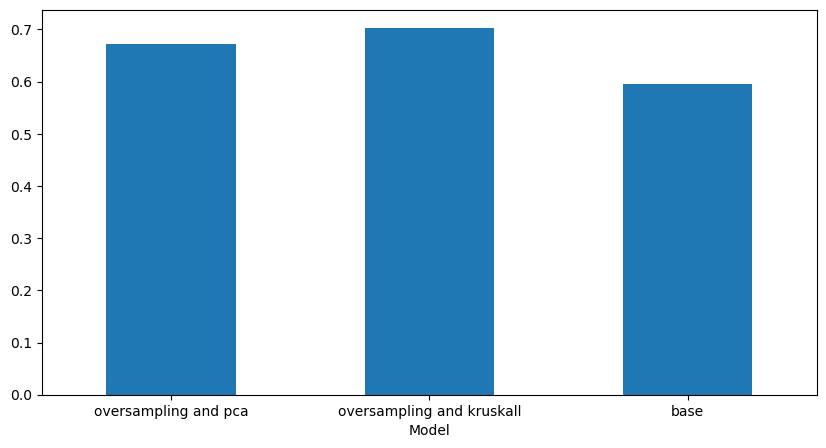

In [260]:
df_metric = pd.DataFrame({'Model':['oversampling and pca', 'oversampling and kruskall','base'], 'roc_auc_score':list_model_auc_score})
ax = df_metric.plot.bar(x='Model', y='roc_auc_score', rot=0, figsize=(10,5), legend=False)

##### Note
*   OverSampling + Kruskall Model is the best

### 4-4. Model Optimization 3: Experiment with the top-performing features from the above results using three ML algorithm candidates (GBM, RF, SVM, MLP)

In [261]:
list_model_opt_metric = []

##### GBM Algorithm

In [267]:
# Define hyperparameters for grid search
hyper_params_gbm = {
    "loss": ["log_loss"],  # corrected from "deviance" to "log_loss"
    "learning_rate": [0.1, 0.5, 1],
    "max_depth": [5, 8, 10],
    "n_estimators": [10, 20, 30]
}

# Create the GradientBoostingClassifier
gbm_clf = GradientBoostingClassifier(random_state=1234)

# Set up GridSearchCV
grid_cv_gbm = GridSearchCV(gbm_clf, param_grid=hyper_params_gbm, cv=cv, n_jobs=n_jobs)

# Fit the model
grid_cv_gbm.fit(X_fs_kruskall, y_over)

# Print best model hyper-parameters
print('best model hyper-parameter : ', grid_cv_gbm.best_params_)

# Predict probabilities on the validation set
y_prd = grid_cv_gbm.predict_proba(X_validation_fs_kruskall)[:, -1]

# Calculate the roc_auc_score
score = roc_auc_score(y_validation, y_prd)
print("roc_auc_score : ", score)

# Append the score to the list of model optimization metrics
list_model_opt_metric.append(score)

best model hyper-parameter :  {'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 8, 'n_estimators': 30}
roc_auc_score :  0.7301387137452711


##### RandomForest Algorithm

In [263]:
hyper_params_rf = {
    "min_samples_split": np.linspace(0.1, 0.5, 2), # linspace (0.1과 0.5사이에 2개// 3개하면 0.1,0.3,0.5)
    "min_samples_leaf": np.linspace(0.1, 0.5, 2),
    "max_depth":[5, 8, 10],
    "n_estimators":[10, 20, 30]
    }

rf_clf = RandomForestClassifier(random_state=1234)
grid_cv_rf = GridSearchCV(rf_clf, param_grid = hyper_params_rf, cv = cv, n_jobs = n_jobs)
grid_cv_rf.fit(X_fs_kruskall, y_over)
print('best model hyper-parameter : ', grid_cv_rf.best_params_)
y_prd = grid_cv_rf.predict_proba(X_validation_fs_kruskall)[:,-1]
score = roc_auc_score(y_validation, y_prd)
print("roc_auc_score : ", score)
list_model_opt_metric.append(score)

best model hyper-parameter :  {'max_depth': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 20}
roc_auc_score :  0.7245691467002944


##### MLP Algorithm

In [264]:
hyper_params_mlp = {
    "hidden_layer_sizes" : [(10,), (20,)],
    "activation" : ["tanh", "relu"],
    "solver" : ["sgd", "adam"]
    }

mlp_clf = MLPClassifier(random_state=1234)
grid_cv_mlp = GridSearchCV(mlp_clf, param_grid = hyper_params_mlp, cv = cv, n_jobs = n_jobs)
grid_cv_mlp.fit(X_fs_kruskall, y_over)
print('best model hyper-parameter : ', grid_cv_mlp.best_params_)
y_prd = grid_cv_mlp.predict_proba(X_validation_fs_kruskall)[:,-1]
score = roc_auc_score(y_validation, y_prd)
print("roc_auc_score : ", score)
list_model_opt_metric.append(score)

/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chulw

best model hyper-parameter :  {'activation': 'relu', 'hidden_layer_sizes': (20,), 'solver': 'adam'}
roc_auc_score :  0.7641866330390921


/Users/chulwonchae/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


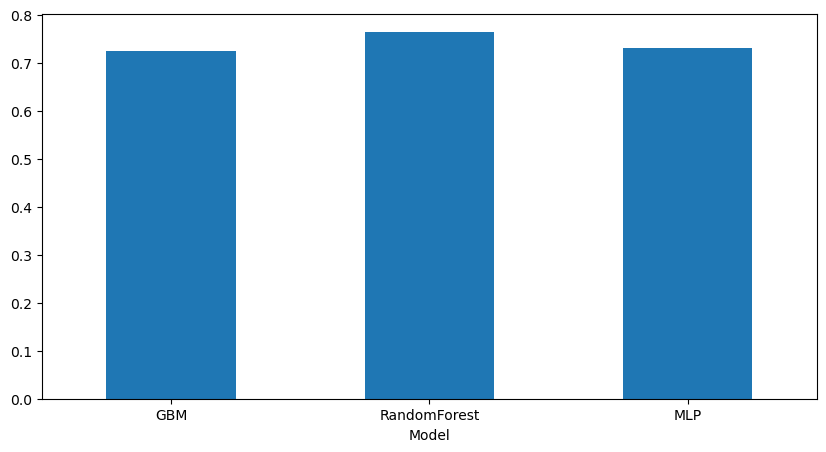

In [268]:
df_metric = pd.DataFrame({'Model':['GBM', 'RandomForest', 'MLP'], 'roc_auc_score':list_model_opt_metric})
ax = df_metric.plot.bar(x='Model', y='roc_auc_score', rot=0, figsize=(10,5), legend=False)

### 4-5. Model Analysis

##### Shapley Value


In [269]:
explainer = shap.Explainer(lambda x : grid_cv_mlp.predict_log_proba(x)[:,1], X_validation_fs_kruskall)
shap_values = explainer(X_validation_fs_kruskall)

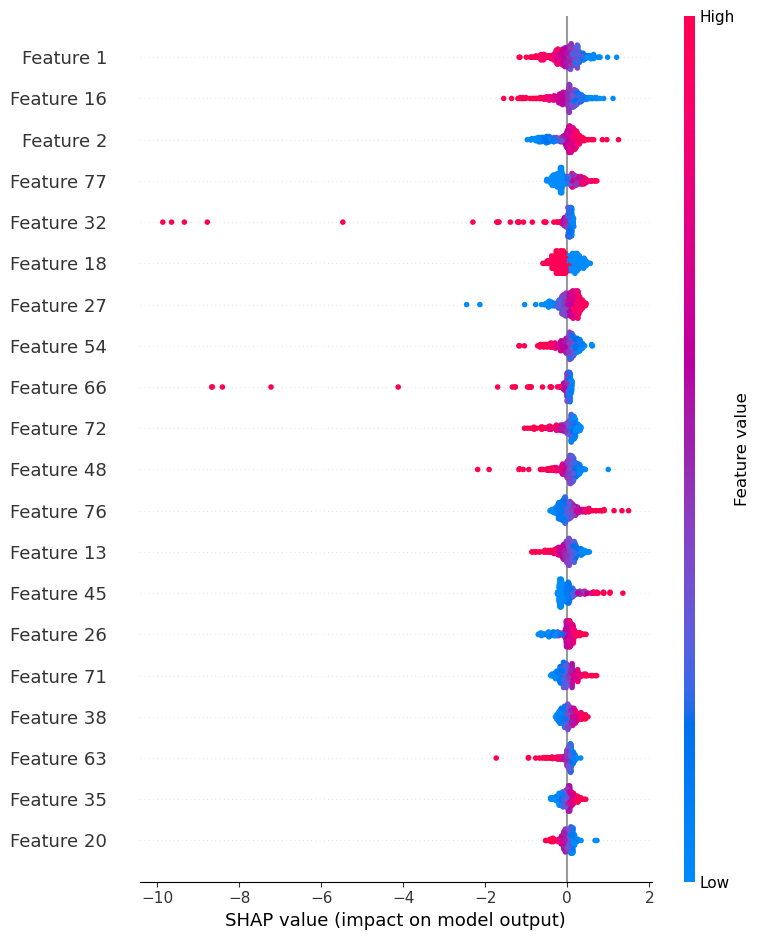

In [270]:
shap.summary_plot(shap_values, X_validation_fs_kruskall)

In [ ]:
# feature 32 has big impact decding 'fail'
# feature 2, 76 has big impact decding 'pass'